In [1]:
#!conda install -c conda-forge librosa
    #librosa.org


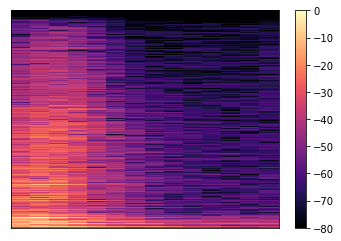

In [1]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

from past.utils import old_div

#filename = librosa.example('nutcracker')
y, sr = librosa.load('/Users/cooky/HDD/Drum/Dilla Drums/!Snare 170.wav')

tempo, beat_frame = librosa.beat.beat_track(y=y, sr=sr)

D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()


In [33]:
#return the avg of eq bands of the sound divided in div

def eq_bands(wav, div):
    freq_spec = librosa.amplitude_to_db(
        librosa.magphase(
            librosa.stft(y=wav,
            n_fft=div+1))[0],
        ref=np.max
    )

    return list([float(x) for x in np.mean(freq_spec, axis=1)])

In [34]:
# return root mean square

def rms(num):
    return float(np.sqrt(np.mean(np.square(num))))

In [35]:
# return how much loud at the pos

def loudness_at(data, pos, window_size=100):
    window_start = max(0, pos - old_div(window_size, 2))
    window_end = min(len(data), window_start + window_size)
    if (window_end - window_start) < window_size:
        window_start = max(0, window_end - window_size)
    windowed = data[int(window_start):int(window_end)]
    return rms(windowed)

In [36]:
#normalize the audio input
# 
def normalize(audio):
    return audio.astype(np.float32) / float(np.amax(np.abs(audio)))

In [58]:
neg80point8db = 0.00009120108393559096
bit_depth = 16

default_silence_threshold = (neg80point8db * (2 ** (bit_depth - 1))) * 4

def start_of(list, threshold=default_silence_threshold, samples_before=1):
    """Estimate where the start of a given signal is, in samples."""
    if int(threshold) != threshold:
        threshold = threshold * float(2 ** (bit_depth - 1))
    index = np.argmax(np.absolute(list) > threshold)
    if index > (samples_before - 1):
        return index - samples_before
    else:
        return 0


def end_of(list, threshold=default_silence_threshold, samples_after=1):
    """Estimate where the end of a given signal is, in samples."""
    if int(threshold) != threshold:
        threshold = threshold * float(2 ** (bit_depth - 1))
    rev_index = np.argmax(
        np.flipud(np.absolute(list)) > threshold
    )
    if rev_index > (samples_after - 1):
        return len(list) - (rev_index - samples_after)
    else:
        return len(list)


def trim_data(
    data,
    start_threshold=default_silence_threshold,
    end_threshold=default_silence_threshold
):
    """Returns a trimmed signal based on its estimated start and end."""
    start = start_of(data, start_threshold)
    end = end_of(data, end_threshold)

    return data[start:end]


In [59]:
#from audio_utils import loudness_at

def load_and_trim(file):
    y, rate = librosa.load(file, mono=True)
    y = normalize(y)
    trimmed_y = trim_data(y)
    return trimmed_y, rate
    

In [71]:
def poorly_estimate_fundamental(y, sample_rate):
    """
    Like it says on the tin, this method returns a rough estimate of the
    fundamental pitch in the given signal over time, along with its stddev.
    """
    pitches, magnitudes = librosa.core.piptrack(
        y=y, sr=sample_rate, fmin=10, fmax=1600)
    fundamental_over_time = [
        pitches[magnitudes[:, t].argmax(), t]
        for t in range(pitches.shape[1])
    ]

    return float(np.amin(fundamental_over_time)), \
        float(np.std(fundamental_over_time))

In [89]:
def features_for(file):
    # Load and trim the audio file to only the parts that aren't silent.
    audio, sample_rate = load_and_trim(file)

    features = {"duration": librosa.get_duration(audio, sample_rate)}

    # Use poorly_estimate_fundamental to figure out what the rough
    # pitch is, along with the standard deviation - how much it varies.
    fundamental, f_stddev = poorly_estimate_fundamental(audio, sample_rate)

    # How loud each low, mid, and high section is
    #low_1, low, mid_1, mid, high_1, high_2, high = eq_bands(audio, 11)
    low, mid, high = eq_bands(audio, 3)

    return {
        "duration":              librosa.get_duration(y=audio, sr=sample_rate),
        "start_loudness":        loudness_at(audio, 0),
        "mid_loudness":          loudness_at(audio, len(audio)/2),
        "end_loudness":          loudness_at(audio, len(audio)),
        "fundamental_freq":      fundamental,
        "fundamental_deviation": f_stddev,
        #"l1": low_1,#
        "average_eq_low":        low,
        #"m1": mid_1,#
        "average_eq_mid":        mid,
        #"h1": high_1,#
        #"h2": high_2,#
        "average_eq_high":       high,
    }

In [80]:
def features_for(file):
    # Load and trim the audio file to only the portions that aren't silent.
    audio, rate = load_and_trim(file)

    features = {"duration": librosa.get_duration(audio, rate)}

    # Let's split up the audio file into chunks
    for (i, section) in enumerate(np.array_split(audio, 10)):
        # And in each of those chunks:
        # ...get the loudness for that chunk
        features["loudness_%d" % i] = rms(section)

        # Use poorly_estimate_fundamental to figure out
        # what the rough pitch is, along with the standard
        # deviation - how much that pitch varies.
        fundamental, fundamental_stddev = \
            poorly_estimate_fundamental(section, rate)
        features["fundamental_%d" % i] = fundamental
        features["fundamental_stddev_%d" % i] = fundamental_stddev

        # ...make a feature out of each of 25 EQ bands.
        for (j, value) in enumerate(eq_bands(section, 99)):
            features["average_eq_%d_%d" % (i, j)] = value

    return features

In [90]:
dit = features_for('/Users/cooky/HDD/Drum/9th Wonder Kit/Hi-Hats/Bld_H1.wav')
print(dit)

{'duration': 0.16580498866213153, 'start_loudness': 0.22940745949745178, 'mid_loudness': 0.015686701983213425, 'end_loudness': 0.00898020714521408, 'fundamental_freq': 0.0, 'fundamental_deviation': 427.3084411621094, 'average_eq_low': -41.10032653808594, 'average_eq_mid': -36.3490104675293, 'average_eq_high': -38.824615478515625}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[-0.06037794  0.07216429 -0.01546111 ... -0.00957059 -0.00536065
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [91]:
dit3 = features_for('/Users/cooky/HDD/Drum/Dilla Drums/Dilla Kk 40.wav')
print(dit3)

{'duration': 0.9683900226757369, 'start_loudness': 0.25362253189086914, 'mid_loudness': 0.0, 'end_loudness': 0.0, 'fundamental_freq': 0.0, 'fundamental_deviation': 170.46881103515625, 'average_eq_low': -55.10514831542969, 'average_eq_mid': -57.82075500488281, 'average_eq_high': -72.56956481933594}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[ 0.00016099 -0.00020534  0.00470769 ...  0.          0.
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [92]:
dit2 = features_for('/Users/cooky/HDD/Drum/Wu-tang mega kit/WU_HH_136.wav')
print(dit2)

{'duration': 0.25065759637188206, 'start_loudness': 0.004940907936543226, 'mid_loudness': 0.0027112506795674562, 'end_loudness': 0.001056976499967277, 'fundamental_freq': 0.0, 'fundamental_deviation': 77.01537322998047, 'average_eq_low': -50.48466491699219, 'average_eq_mid': -51.2275276184082, 'average_eq_high': -56.70635223388672}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[-0.00607497 -0.009378   -0.0084612  ... -0.00150935 -0.0022387
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [93]:
dit4 = features_for('/Users/cooky/HDD/Drum/Marco Polo Pad Thai Vol. 1/Kicks/Kick 2 Nostalgia.wav')
print(dit4)

{'duration': 0.7100680272108844, 'start_loudness': 0.08242890983819962, 'mid_loudness': 0.00034455748391337693, 'end_loudness': 2.815491461660713e-05, 'fundamental_freq': 0.0, 'fundamental_deviation': 30.81185531616211, 'average_eq_low': -59.33082580566406, 'average_eq_mid': -63.953514099121094, 'average_eq_high': -78.28298950195312}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[ 2.8306966e-05 -1.0208494e-04  3.1452171e-05 ... -1.0771130e-05
 -2.0925869e-05 -9.7559823e-06], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [94]:
dit5 = features_for('/Users/cooky/HDD/Drum/Marco Polo Pad Thai Vol. 1/Snares and Claps/Snare 2 NOBODY.wav')
print(dit5)

{'duration': 1.207437641723356, 'start_loudness': 1.754942786647007e-05, 'mid_loudness': 0.004058435559272766, 'end_loudness': 2.4684364689164795e-05, 'fundamental_freq': 0.0, 'fundamental_deviation': 96.78923034667969, 'average_eq_low': -59.010093688964844, 'average_eq_mid': -60.77033615112305, 'average_eq_high': -65.80193328857422}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[ 9.0655058e-06  1.2955057e-05  9.3186336e-06 ... -1.1315885e-05
 -2.7218310e-05 -4.6448564e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [95]:
dit6 = features_for('/Users/cooky/HDD/Drum/Dilla Drums/!Snare 185.wav')
print(dit6)

{'duration': 0.22131519274376418, 'start_loudness': 0.32855406403541565, 'mid_loudness': 0.013084937818348408, 'end_loudness': 0.007011371199041605, 'fundamental_freq': 26.677412033081055, 'fundamental_deviation': 142.4845428466797, 'average_eq_low': -37.32543182373047, 'average_eq_mid': -40.599422454833984, 'average_eq_high': -54.00895690917969}


/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_7046/701583641.py:5: FutureWarning: Pass y=[-0.00367063 -0.00185261 -0.00378984 ...  0.00950995  0.00612636
  0.00620077], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = {"duration": librosa.get_duration(audio, sample_rate)}


In [96]:
import pandas as pd

dd = [dit, dit2, dit3, dit4, dit5, dit6]

d1 = pd.DataFrame.from_dict(dd)

print(d1)

   duration  start_loudness  mid_loudness  end_loudness  fundamental_freq  \
0  0.165805        0.229407      0.015687      0.008980          0.000000   
1  0.250658        0.004941      0.002711      0.001057          0.000000   
2  0.968390        0.253623      0.000000      0.000000          0.000000   
3  0.710068        0.082429      0.000345      0.000028          0.000000   
4  1.207438        0.000018      0.004058      0.000025          0.000000   
5  0.221315        0.328554      0.013085      0.007011         26.677412   

   fundamental_deviation  average_eq_low  average_eq_mid  average_eq_high  
0             427.308441      -41.100327      -36.349010       -38.824615  
1              77.015373      -50.484665      -51.227528       -56.706352  
2             170.468811      -55.105148      -57.820755       -72.569565  
3              30.811855      -59.330826      -63.953514       -78.282990  
4              96.789230      -59.010094      -60.770336       -65.801933  
5   

In [88]:
d1.to_csv('asdf.csv')

In [1]:
# for macos m1 gpu

import tensorflow.compat.v2 as tf


In [28]:
# for window

import tensorflow as tf

In [ ]:
tf.enable_v2_behavior()

In [24]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [29]:
print(tf.__version__)

2.8.0


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
model.fit(
    ds_train,
    epochs=12,
    validation_data=ds_test,
)

In [4]:
import cv2

img = cv2.imread('/Users/cooky/Documents/GitHub/0220dbtest/img/Hip Hop/3487.jpeg', 0)
hist = cv2.calcHist([img],[0],None,[256],[0,256])

In [5]:
print(type(hist))

print(hist)

<class 'numpy.ndarray'>
[[ 45.]
 [ 13.]
 [ 15.]
 [ 20.]
 [ 28.]
 [ 41.]
 [ 43.]
 [ 81.]
 [ 74.]
 [ 66.]
 [114.]
 [282.]
 [156.]
 [322.]
 [148.]
 [207.]
 [190.]
 [217.]
 [214.]
 [212.]
 [178.]
 [228.]
 [172.]
 [204.]
 [184.]
 [202.]
 [167.]
 [191.]
 [266.]
 [233.]
 [276.]
 [457.]
 [262.]
 [423.]
 [255.]
 [244.]
 [246.]
 [206.]
 [252.]
 [216.]
 [191.]
 [189.]
 [178.]
 [173.]
 [196.]
 [178.]
 [187.]
 [131.]
 [129.]
 [134.]
 [139.]
 [128.]
 [136.]
 [132.]
 [118.]
 [127.]
 [128.]
 [120.]
 [104.]
 [ 88.]
 [ 84.]
 [ 94.]
 [ 83.]
 [ 96.]
 [ 94.]
 [ 98.]
 [ 98.]
 [ 75.]
 [ 84.]
 [ 80.]
 [ 91.]
 [ 81.]
 [ 68.]
 [ 79.]
 [ 86.]
 [ 87.]
 [ 74.]
 [ 87.]
 [116.]
 [ 77.]
 [ 80.]
 [119.]
 [106.]
 [ 92.]
 [ 92.]
 [ 84.]
 [106.]
 [ 90.]
 [ 88.]
 [ 96.]
 [ 88.]
 [ 75.]
 [102.]
 [ 85.]
 [ 98.]
 [ 74.]
 [ 78.]
 [ 82.]
 [ 77.]
 [ 79.]
 [ 75.]
 [ 82.]
 [ 67.]
 [ 63.]
 [ 68.]
 [ 92.]
 [ 67.]
 [ 75.]
 [ 87.]
 [ 88.]
 [ 63.]
 [ 80.]
 [ 75.]
 [ 78.]
 [ 75.]
 [ 78.]
 [ 75.]
 [ 79.]
 [ 84.]
 [ 90.]
 [ 72.]
 [ 81.]


In [6]:
plt.hist(img.ravel(),256,[0,256])
plt.show()

NameError: name 'plt' is not defined

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_io as tfio

In [3]:
@tf.function
def load_mono(file):
    file_cont = tf.io.read_file(file)
    wav, sr = tf.audio.decode_wav(
        file_cont,
        desired_channels=1
    )
    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)
    # wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
    return wav

In [5]:
k = load_mono('/Users/cooky/HDD/Drum/Dilla Drums/!Snare 170.wav')

In [6]:
k.shape

TensorShape([14135])